In this notebook we will explore collective classification using lyrics framework

In [36]:
import tensorflow as tf
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

In [37]:
from lyrics.lyrics import (
    Domain,
    Predicate,
    Constraint,
    PointwiseConstraint,
)
from lyrics.world import current_world as world

In [38]:
np.random.seed(3)
tf.random.set_seed(3)

Create our domaine domain = [-2,2]*[-2,2]

In [4]:
ls = np.linspace(-2,2, 16,dtype=np.float32)
xx, yy = np.meshgrid(ls,ls)
domain = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)
np.random.shuffle(domain)

For the classes *A* and *B* we take 32 supervised examples, for class *C* we take only 10 examples. The rest are takes for tests

In [5]:
supervised = domain[:32]
test = domain[32:]
supervised_C = supervised[:10]

Labels of the different supervised training points

In [7]:
labels_A = (supervised[:,0] <= 1.).astype(np.int8)
labels_B = ((supervised[:,0] >= -1) & (supervised[:,0] <= 2)).astype(np.int8)
labels_C = ((supervised_C[:,0] >= -1) & (supervised_C[:,0] <= 1)).astype(np.int8)

Labels for the test datapoints

In [8]:
labels_test_A = (test[:,0] <= 1.).astype(np.int8)
labels_test_B = ((test[:,0] >= -1) & (test[:,0] <= 2)).astype(np.int8)
labels_test_C = ((test[:,0] >= -1) & (test[:,0] <= 1)).astype(np.int8)

Plot supervised datapoints. For each subplot, green means that the point is of that class, red means no of that class

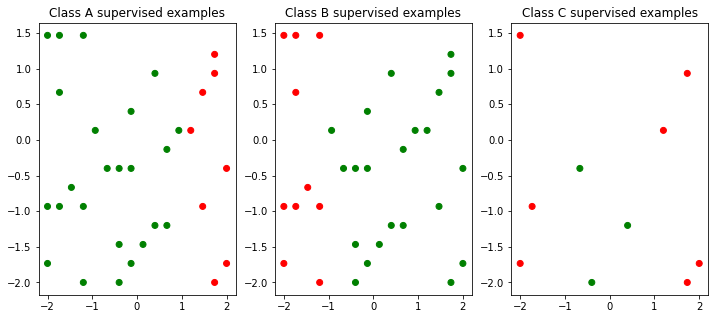

In [9]:
plt.figure(figsize=(4 * 3,5))
plt.subplot(1,3, 1).title.set_text('Class A supervised examples')
plt.scatter(supervised[:,0], supervised[:,1], color=['g' if l else 'r' for l in labels_A])
plt.subplot(1,3, 2).title.set_text('Class B supervised examples')
plt.scatter(supervised[:,0], supervised[:,1], color=['g' if l else 'r' for l in labels_B])
plt.subplot(1,3, 3).title.set_text('Class C supervised examples')
plt.scatter(supervised_C[:,0], supervised_C[:,1], color=['g' if l else 'r' for l in labels_C])
plt.show()

Create a neural network that is trained using supervised data points and used to predict if some point is of a given class or not using x-y coordinates

In [10]:
class FCL(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FCL, self).__init__(**kwargs)
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(5, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    def call(self, inputs):
        return self.model(inputs)
    
    def cost(self, y, x):
        y_hat = self.call(x)
        losses = tf.keras.losses.binary_crossentropy(y,y_hat, from_logits=True)
        return tf.reduce_mean(losses)

Instantiate three neural networks. One for each class *A* or *B* or *C*

In [11]:
is_A, is_B, is_C = FCL(),FCL(),FCL()

Add three pointwise constraints on the different neural network in order to explain data

In [12]:
ptc_1 = PointwiseConstraint(is_A, labels_A.reshape(-1,1), supervised)
ptc_2 = PointwiseConstraint(is_B, labels_B.reshape(-1,1), supervised)
ptc_3 = PointwiseConstraint(is_C, labels_C.reshape(-1,1), supervised_C)

A training step for the supervised data

In [13]:
optimizer = tf.keras.optimizers.Adam()
@tf.function
def train_step_supervised(model):
    with tf.GradientTape() as tape:
        loss = model.loss()
        grads = tape.gradient(loss, {'A':is_A.trainable_variables, 'B':is_B.trainable_variables, 'C':is_C.trainable_variables})
    optimizer.apply_gradients(zip(grads['A'], is_A.trainable_variables))
    optimizer.apply_gradients(zip(grads['B'], is_B.trainable_variables))
    optimizer.apply_gradients(zip(grads['C'], is_C.trainable_variables))
    return loss

A general training loop

In [14]:
def train(model, nb_epochs, train_step_function):
    epochs = range(1,nb_epochs + 1)
    print('Loss at epoch 0 = {}'.format(model.loss()))
    for epoch in epochs:
        loss = train_step_function(model)
        if epoch % 1000 == 0:
            print('Loss at epoch {} = {}'.format(epoch, loss))

Train the 3 neural networks on the supervised data

In [15]:
train(world, 2000, train_step_supervised)

Loss at epoch 0 = 2.9796361923217773
Loss at epoch 1000 = 0.32895535230636597
Loss at epoch 2000 = 0.11340063065290451


See how the different networks perform on the supervised and test datapoints

In [16]:
prediction_supervised_A = (tf.math.sigmoid(is_A(supervised)) > 0.5).numpy().astype(np.int8).reshape(-1,)
prediction_supervised_B = (tf.math.sigmoid(is_B(supervised)) > 0.5).numpy().astype(np.int8).reshape(-1,)
prediction_supervised_C = (tf.math.sigmoid(is_C(supervised_C)) > 0.5).numpy().astype(np.int8).reshape(-1,)

In [17]:
prediction_test_A = (tf.math.sigmoid(is_A(test)) > 0.5).numpy().astype(np.int8).reshape(-1,)
prediction_test_B = (tf.math.sigmoid(is_B(test)) > 0.5).numpy().astype(np.int8).reshape(-1,)
prediction_test_C = (tf.math.sigmoid(is_C(test)) > 0.5).numpy().astype(np.int8).reshape(-1,)

In [18]:
is_correct_supervised_A = (prediction_supervised_A == labels_A)
is_correct_supervised_B = (prediction_supervised_B == labels_B)
is_correct_supervised_C = (prediction_supervised_C == labels_C)

In [19]:
is_correct_test_A = (prediction_test_A == labels_test_A)
is_correct_test_B = (prediction_test_B == labels_test_B)
is_correct_test_C = (prediction_test_C == labels_test_C)

These 3 subplots represent the performance of our 3 networks on the supervised data.


Green means the point was correctly classified, red means otherwise.


Notice how the three networks were able to perfectly explain supervised data and notice that class C has particularily less trianing examples.

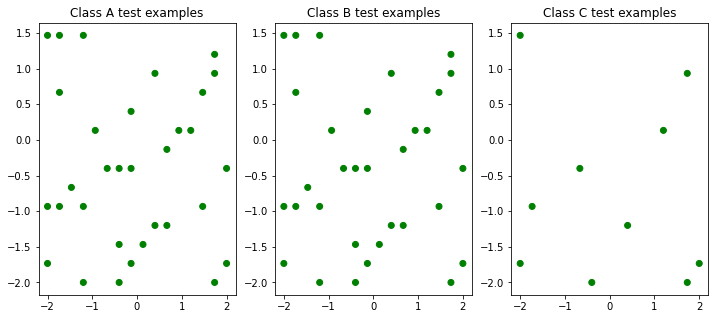

In [20]:
plt.figure(figsize=(4 * 3,5))
plt.subplot(1,3, 1).title.set_text('Class A test examples')
plt.scatter(supervised[:,0], supervised[:,1], color=['g' if l else 'r' for l in is_correct_supervised_A])
plt.subplot(1,3, 2).title.set_text('Class B test examples')
plt.scatter(supervised[:,0], supervised[:,1], color=['g' if l else 'r' for l in is_correct_supervised_B])
plt.subplot(1,3, 3).title.set_text('Class C test examples')
plt.scatter(supervised_C[:,0], supervised_C[:,1], color=['g' if l else 'r' for l in is_correct_supervised_C])
plt.show()

These 3 subplots represent the performance of our 3 networks on the **test** data.


Green means the point was correctly classified, red means otherwise.


Notice how networks *A* and *B* perform better than network *C* given that they had more examples (32 vs 10).

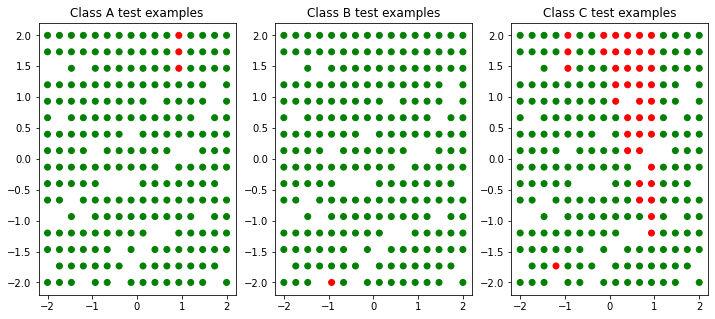

In [21]:
plt.figure(figsize=(4 * 3,5))
plt.subplot(1,3, 1).title.set_text('Class A test examples')
plt.scatter(test[:,0], test[:,1], color=['g' if l else 'r' for l in is_correct_test_A])
plt.subplot(1,3, 2).title.set_text('Class B test examples')
plt.scatter(test[:,0], test[:,1], color=['g' if l else 'r' for l in is_correct_test_B])
plt.subplot(1,3, 3).title.set_text('Class C test examples')
plt.scatter(test[:,0], test[:,1], color=['g' if l else 'r' for l in is_correct_test_C])
plt.show()

# Collective classification

Clear the previous world (remove the previous pointwise constraints)

In [22]:
world.point_wise_constraints = []

Create an indexing model used to hold learnable features of indexable individuals.

In [23]:
class Index(tf.keras.layers.Layer):
    def __init__(self, initial_values):
        super(Index, self).__init__()
        self.collective_vars = tf.Variable(initial_values)
    
    def call(self, indices):
        return tf.nn.sigmoid(tf.gather(self.collective_vars,tf.cast(indices, tf.int32)))
    
    def cost(self, y, indices):
        y_hat = self.call(indices)
        loss = tf.keras.losses.MSE(y,y_hat)
        return loss

Priors of the three different classes using the previous neural networks.

In [24]:
prior_A = is_A(test).numpy().reshape(-1,)
prior_B = is_B(test).numpy().reshape(-1,)
prior_C = is_C(test).numpy().reshape(-1,)

Instantiate 3 indexing models initialized with the priors of the corresponding classes.

In [25]:
idx_A, idx_B, idx_C = Index(prior_A), Index(prior_B), Index(prior_C)

Our new world is now symbolic. Individuals (points) are identified using a unique integer index

In [26]:
indices = np.arange(len(test))

Create a 'points' domain using indices as elements

In [27]:
points = Domain(domain_name="points", elements=indices.reshape(-1,1))

Define three predicate for each class (*A*, *B* or *C*). Indexing functions (e.g idx_A) take as input an index and returns a fuzzy logic probability for the indexed point as being of a given class or not.

In [28]:
Predicate(predicate_name="A", domains=("points",), concrete_function=idx_A)
Predicate(predicate_name="B", domains=("points",), concrete_function=idx_B)
Predicate(predicate_name="C", domains=("points",), concrete_function=idx_C)

Add three points wise constraints on out priors. We would like or collective classification model to be close to the priors.

Notice that the weights of the two first constraints (400) are much bigger than that of the last one. This is because we are much more confident in the priors of classes *A* and *B* (given that they had more training examples) and we don't want our collective classification procedure to deviate a lot from them. We are not very well confident about the priors of class C (only few training examples) on the other hand.

In [29]:
PointwiseConstraint(concrete_function=idx_A, y=tf.sigmoid(prior_A),  x=indices, weight=400)
PointwiseConstraint(concrete_function=idx_B, y=tf.sigmoid(prior_B),  x=indices, weight=400)
PointwiseConstraint(concrete_function=idx_C, y=tf.sigmoid(prior_C),  x=indices, weight=1)

Add two high level constraints. These constraints will help us improve our classification procedure. Especially classification of *C* classes.

For e.g. the second constraint constraint *`forall x: (B(x) and A(x)) -> C(x)`* will help us correct prediction for class C where we are confident that *A* and *B* hold.  See previous results on test datapoints.

In [30]:
Constraint("forall x: A(x) or B(x)",weight=2)
Constraint("forall x: (B(x) and A(x)) -> C(x)",weight=2)

A tensorflow training step for the collective classification

In [31]:
optimizer = tf.keras.optimizers.Adam()
@tf.function
def train_step_collective(model):
    with tf.GradientTape() as tape:
        loss = model.loss()
        grads = tape.gradient(loss, {'A':idx_A.trainable_variables, 'B':idx_B.trainable_variables, 'C':idx_C.trainable_variables})
    optimizer.apply_gradients(zip(grads['A'], idx_A.trainable_variables))
    optimizer.apply_gradients(zip(grads['B'], idx_B.trainable_variables))
    optimizer.apply_gradients(zip(grads['C'], idx_C.trainable_variables))
    return loss

Train the collective classification model for more epochs

In [32]:
train(world, 20000, train_step_collective)

Loss at epoch 0 = 1.7845158576965332
Loss at epoch 1000 = 1.5823657512664795
Loss at epoch 2000 = 1.5171923637390137
Loss at epoch 3000 = 1.4615535736083984
Loss at epoch 4000 = 1.3988571166992188
Loss at epoch 5000 = 1.3219844102859497
Loss at epoch 6000 = 1.2279644012451172
Loss at epoch 7000 = 1.1269418001174927
Loss at epoch 8000 = 1.04720938205719
Loss at epoch 9000 = 0.9883134365081787
Loss at epoch 10000 = 0.9433856010437012
Loss at epoch 11000 = 0.9054537415504456
Loss at epoch 12000 = 0.8710862398147583
Loss at epoch 13000 = 0.8365813493728638
Loss at epoch 14000 = 0.7991248369216919
Loss at epoch 15000 = 0.7570655345916748
Loss at epoch 16000 = 0.7082372307777405
Loss at epoch 17000 = 0.6521090269088745
Loss at epoch 18000 = 0.5891668796539307
Loss at epoch 19000 = 0.5299524068832397
Loss at epoch 20000 = 0.481523722410202


In [33]:
prediction_test_A = (idx_A(indices) > 0.5).numpy().astype(np.int8).reshape(-1,)
prediction_test_B = (idx_B(indices) > 0.5).numpy().astype(np.int8).reshape(-1,)
prediction_test_C = (idx_C(indices) > 0.5).numpy().astype(np.int8).reshape(-1,)

In [34]:
is_correct_test_A = (prediction_test_A == labels_test_A)
is_correct_test_B = (prediction_test_B == labels_test_B)
is_correct_test_C = (prediction_test_C == labels_test_C)

Notice how the classificatio for class C improves considerably. Especially for x in [-1,1] where we are confident that A(x) and B(x) holds, this helps increase C(x) to satisfy the second constraint *`forall x: (B(x) and A(x)) -> C(x)`*

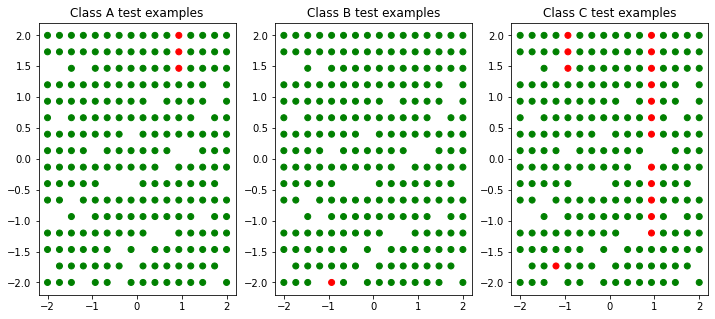

In [35]:
plt.figure(figsize=(4 * 3,5))
plt.subplot(1,3, 1).title.set_text('Class A test examples')
plt.scatter(test[:,0], test[:,1], color=['g' if l else 'r' for l in is_correct_test_A])
plt.subplot(1,3, 2).title.set_text('Class B test examples')
plt.scatter(test[:,0], test[:,1], color=['g' if l else 'r' for l in is_correct_test_B])
plt.subplot(1,3, 3).title.set_text('Class C test examples')
plt.scatter(test[:,0], test[:,1], color=['g' if l else 'r' for l in is_correct_test_C])
plt.show()